In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from common import helpers
from glob import glob
from os import path
import pandas as pd
from itertools import groupby

In [3]:
def get_linear_section(data):
    '''Given a dataframe or series, return the indices of the longest linear section.'''
    
    # Compute the gradient
    grad = np.gradient(data)
    
    # Determine if each value is increasing
    increasing = grad > 0
    
    # Find the longest sequence of increasing values
    max_len = 0
    max_start = 0
    current_len = 0
    current_start = 0
    for i, (key, group) in enumerate(groupby(increasing)):
        length = len(list(group))
        if key:  # If the group represents increasing values
            current_len = length
            if current_len > max_len:
                max_len = current_len
                if i > current_len - 1:
                    max_start = i - current_len + 1
                else:
                    max_start = current_start
        else:
            current_len = 0

    # Return the linear section
    return (data.index[max_start], data.index[max_start + max_len - 1]) # Start and end indices
    

In [4]:
# Load the raw files by the keyword 'lin_test'
root = r'D:\CZI_scope\code\data\raw'
files = glob(path.join(root, '*10-16_*lin_test_*.raw'))

data_frames = []

for file in files:
    power = int(file.split('_')[-1].split('.')[0])
    iterator = helpers.load_evts_from_file(file)
    df = helpers.evts_to_df(iterator)
    df['power'] = power
    # fill 0 values with NaN
    
    data_frames.append(df)

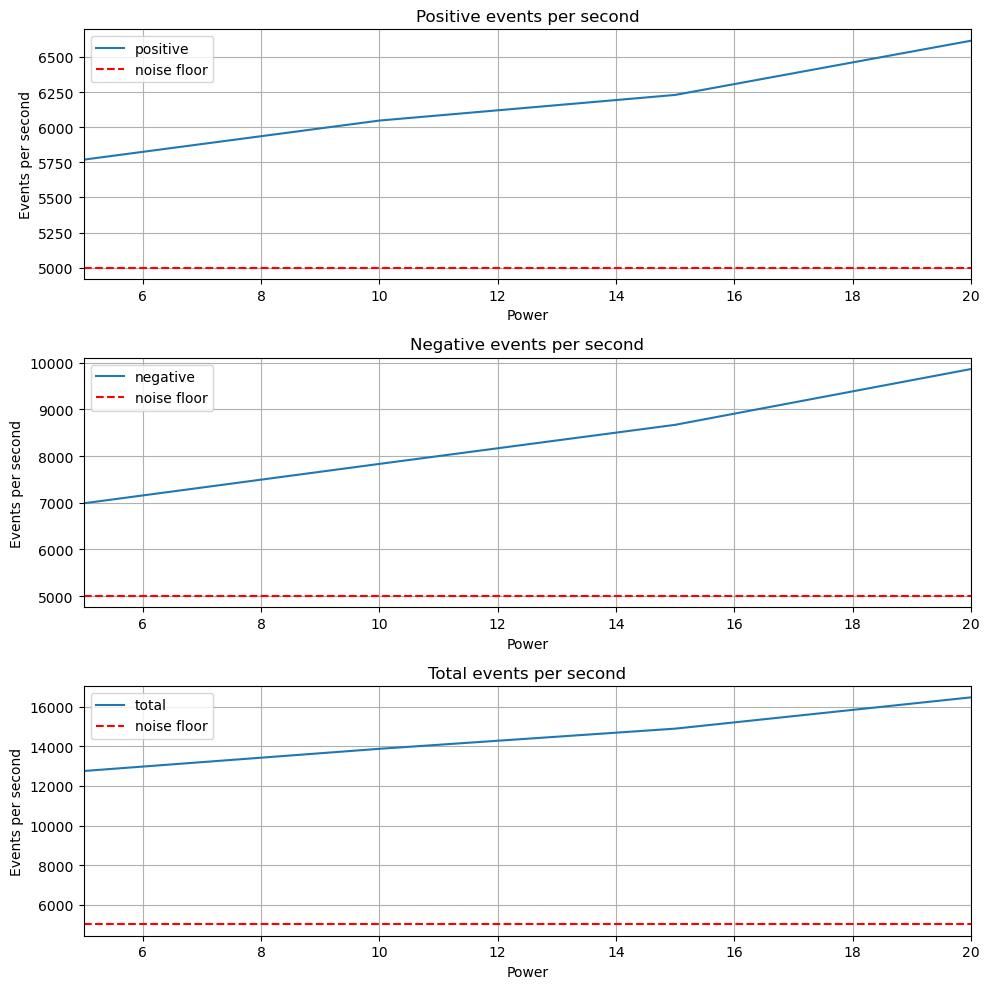

In [6]:

    
df = pd.concat(data_frames)
#df['power'] = df['power'].astype('category')
#df['power_ordered'] = df['power'].as_type('int').cat.as_ordered()


# get the negative events for each power level
negative_events = df[df['p'] == 0].groupby("power")
# get the positive events for each power level
positive_events = df[df['p'] == 1].groupby("power")
# get the total events for each power level
total_events = df.groupby("power")


# calculate the total time span for each power level
positive_time_spans = positive_events["t"].apply(lambda x: (x.max() - x.min()) / 1e6)
negative_time_spans = negative_events["t"].apply(lambda x: (x.max() - x.min()) / 1e6)
total_time_spans = total_events["t"].apply(lambda x: (x.max() - x.min()) / 1e6)


# calculate the events per second for each power level
positive_events_per_second = positive_events.size() / positive_time_spans
negative_events_per_second = negative_events.size() / negative_time_spans
total_events_per_second = total_events.size() / total_time_spans

pos_linear_section = get_linear_section(positive_events_per_second)
neg_linear_section = get_linear_section(negative_events_per_second)
total_linear_section = get_linear_section(total_events_per_second)


# plot the results
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    
axs[0].plot(positive_events_per_second, label="positive")
axs[0].set_title("Positive events per second")
axs[1].plot(negative_events_per_second, label="negative")
axs[1].set_title("Negative events per second")
axs[2].plot(total_events_per_second, label="total")
axs[2].set_title("Total events per second")

# plot the linear sections
# for ax, section in zip(axs, [pos_linear_section, neg_linear_section, total_linear_section]):
#     ax.axvline(section[0], color="red", linestyle="--", label="linear section")
#     ax.axvline(section[1], color="red", linestyle="--", )

# plot the noise floor 5000 events per second
for ax in axs:
    ax.axhline(5000, color="red", linestyle="--", label="noise floor")

# setup common parameters
for ax in axs:
    ax.set_xlabel("Power")
    ax.set_ylabel("Events per second")
    #ax.set_ylim((1e3, 15e3))
    ax.set_xlim(df['power'].min(), df['power'].max())
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
